Model Export

In [280]:
# from ultralytics import YOLO

In [281]:
# # Load a model
# model = YOLO("yolov8l.pt")  # load an official model

# # Export the model
# model.export(format="onnx")

Object Detection

In [282]:
import onnx
import onnxruntime as ort
import PIL
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
import ast

In [283]:
YOLOV8_SIZE = 640
# filename = "../assets/onnx/yolov8n.onnx"
# filename = "../assets/onnx/yolov8s.onnx"
# filename = "../assets/onnx/yolov8m.onnx"
# filename = "../assets/onnx/yolov8l.onnx"
# filename = "../assets/onnx/yolov9c.onnx"
filename = "../assets/onnx/yolov9e.onnx"

In [284]:
def pad_square(image):
    print(type(image))
    if type(image) == PIL.Image.Image or PIL.JpegImagePlugin.JpegImageFile:
        height, width = image.size#[:2]
        new_image = Image.new('RGB', (height, height), (255, 255, 255))
        if height > width:
            # new_image.paste(image, (int((height - width) / 2), 0))
            new_image.paste(image, (0, -int((width - height) / 2)))
        else:
            # new_image.paste(image, (0, int((width - height) / 2)))
            new_image.paste(image, (int((height - width) / 2), 0))
    return new_image

In [285]:
original_image = Image.open("../test_images/obj_det/women_umbrella.jpg")
# original_image = Image.open("../test_images/obj_det/computer_desk.jpg")
original_size = original_image.size
image = original_image.resize((YOLOV8_SIZE, YOLOV8_SIZE)) # ALT1
padded_image = pad_square(original_image) # ALT2
# image = padded_image.resize((YOLOV8_SIZE, YOLOV8_SIZE)) # ALT2
scale_factor = [original_size[0] / YOLOV8_SIZE, original_size[1] / YOLOV8_SIZE] # x, y

<class 'PIL.JpegImagePlugin.JpegImageFile'>


In [286]:
ort_session = ort.InferenceSession(filename, providers=["CPUExecutionProvider"])

In [287]:
model = onnx.load(filename)

In [288]:
class_dict = ast.literal_eval(model.metadata_props[-1].value)

In [289]:
class_dict

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

In [290]:
def BCHW(a):
    a = a.transpose(2, 0, 1)
    return a[np.newaxis, :]

In [291]:
ort_inputs = {"images": BCHW(np.array(image, dtype=np.float32)/255)}

In [292]:
ort_outputs = ort_session.run(None, ort_inputs)
ort_outputs[0].shape

(1, 84, 8400)

In [293]:
preds = ort_outputs[0][0, ...]

In [294]:
# contains_object = preds[4, :] > 0.1 # NOTE WRONG; there's no "objectness" - just individual confidences per each class - so need to manually max.
contains_object = np.max(preds[4:, :], axis=0) > 0.5

In [295]:
contains_object.shape

(8400,)

In [296]:
np.sum([contains_object])

110

In [297]:
relevant_preds = preds[:, contains_object]

In [298]:
def center_coords_to_box_coords(cx, cy, w, h):
    x_left = int(cx - w / 2)
    x_right = int(cx + w / 2)
    y_top = int(cy - h / 2)
    y_bottom = int(cy + h / 2)
    return x_left, x_right, y_top, y_bottom

In [299]:
# viz = np.array(original_image.copy())
viz = np.array(image.copy())

for relevant_pred in relevant_preds.T:
    print(relevant_pred.shape)

    cx, cy, w, h = relevant_pred[:4]
    # cx, w = cx*scale_factor[0], w*scale_factor[0] # NOTE pretty sure this is wrong.
    # cy, h = cy*scale_factor[1], h*scale_factor[1] 
    (x_l, x_r, y_t, y_b) = center_coords_to_box_coords(cx, cy, w, h)

    viz = cv2.rectangle(viz, (x_l, y_t), (x_r, y_b), (0, 255, 0), 2)

    likely_class = class_dict[relevant_pred[4:].argmax()]
    print(likely_class)
    viz = cv2.putText(viz, likely_class, (x_l, y_t-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

(84,)
car
(84,)
car
(84,)
car
(84,)
car
(84,)
car
(84,)
car
(84,)
car
(84,)
car
(84,)
car
(84,)
car
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
person
(84,)
person
(84,)
person
(84,)
person
(84,)
person
(84,)
person
(84,)
person
(84,)
person
(84,)
person
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
umbrella
(84,)
person
(84,)
person
(84,)
p

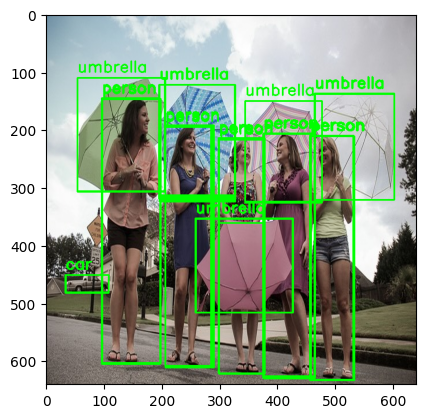

In [300]:
plt.imshow(viz)

In [301]:
# # Python program to explain cv2.rectangle() method  
   
# # importing cv2  
# import cv2  
   
# # path  
# path = "../test_images/obj_det/women_umbrella.jpg"
   
# # Reading an image in default mode 
# image = cv2.imread(path) 
   
# # Window name in which image is displayed 
# window_name = 'Image'
  
# # Start coordinate, here (5, 5) 
# # represents the top left corner of rectangle 
# start_point = (5, 5) 
  
# # Ending coordinate, here (220, 220) 
# # represents the bottom right corner of rectangle 
# end_point = (220, 220) 
  
# # Blue color in BGR 
# color = (255, 0, 0) 
  
# # Line thickness of 2 px 
# thickness = 2
  
# # Using cv2.rectangle() method 
# # Draw a rectangle with blue line borders of thickness of 2 px 
# image = cv2.rectangle(image, start_point, end_point, color, thickness) 
  
# # Displaying the image  
# plt.imshow(image)  

Semantic Segmentation

In [302]:
seg_filename = "../assets/onnx/yolov8m-seg.onnx"

In [303]:
seg_session = ort.InferenceSession(seg_filename, providers=["CPUExecutionProvider"])

In [304]:
seg_output0, seg_output1 = seg_session.run(None, ort_inputs)

In [330]:
boxes = seg_output0[0,0:84]#[:,0:84]
masks = seg_output0[0,84:]#[:,84:]

In [331]:
boxes.shape

(84, 8400)

In [332]:
masks.shape

(32, 8400)

In [333]:
masks[0,...].shape

(8400,)

In [334]:
masks[0,...].T.shape

(8400,)

In [335]:
seg_output1.shape

(1, 32, 160, 160)

In [336]:
seg_output1[0,...].shape

(32, 160, 160)

In [337]:
seg_output1_flat = seg_output1.reshape(32,160*160)

In [338]:
seg_output1_flat.shape

(32, 25600)

In [339]:
matmuled_masks = masks.T @ seg_output1_flat

In [340]:
matmuled_masks.shape

(8400, 25600)

In [341]:
# https://dev.to/andreygermanov/how-to-implement-instance-segmentation-using-yolov8-neural-network-3if9#join_masks

def intersection(box1,box2):
    box1_x1,box1_y1,box1_x2,box1_y2 = box1[:4]
    box2_x1,box2_y1,box2_x2,box2_y2 = box2[:4]
    x1 = max(box1_x1,box2_x1)
    y1 = max(box1_y1,box2_y1)
    x2 = min(box1_x2,box2_x2)
    y2 = min(box1_y2,box2_y2)
    return (x2-x1)*(y2-y1)

def union(box1,box2):
    box1_x1,box1_y1,box1_x2,box1_y2 = box1[:4]
    box2_x1,box2_y1,box2_x2,box2_y2 = box2[:4]
    box1_area = (box1_x2-box1_x1)*(box1_y2-box1_y1)
    box2_area = (box2_x2-box2_x1)*(box2_y2-box2_y1)
    return box1_area + box2_area - intersection(box1,box2)

def iou(box1,box2):
    return intersection(box1,box2)/union(box1,box2)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [342]:
def get_mask(row,box):
    mask = row.reshape(160,160)
    mask = (sigmoid(mask) > 0.8).astype('uint8')*255
    return mask

In [343]:
img_width, img_height = original_size

# parse and filter detected objects
objects = []
for i, row in enumerate(boxes.T):
    prob = row[4:84].max()
    if prob < 0.5:
        continue
    xc,yc,w,h = row[:4]
    class_id = row[4:84].argmax()
    x1 = (xc-w/2)/640*img_width
    y1 = (yc-h/2)/640*img_height
    x2 = (xc+w/2)/640*img_width
    y2 = (yc+h/2)/640*img_height
    label = class_dict[class_id]
    mask = get_mask(matmuled_masks[i,:],(x1,y1,x2,y2))
    print(i, round(prob, 2), label)
    # objects.append([x1,y1,x2,y2,label,prob,mask])

# # apply non-maximum suppression to filter duplicated
# # boxes
# objects.sort(key=lambda x: x[5], reverse=True)
# result = []
# while len(objects)>0:
#     result.append(objects[0])
#     objects = [object for object in objects if iou(object,objects[0])<0.7]

# print(len(result))


4649 0.55 car
6856 0.71 umbrella
6895 0.81 umbrella
6896 0.81 umbrella
6897 0.81 umbrella
6935 0.82 umbrella
6936 0.79 umbrella
6937 0.84 umbrella
6944 0.74 umbrella
6945 0.74 umbrella
6946 0.71 umbrella
6952 0.53 umbrella
6975 0.74 umbrella
6976 0.79 umbrella
6977 0.85 umbrella
6984 0.73 umbrella
6985 0.81 umbrella
6986 0.73 umbrella
6992 0.55 umbrella
6993 0.51 umbrella
7025 0.65 umbrella
7033 0.52 umbrella
7180 0.53 person
7181 0.54 person
7182 0.55 person
7421 0.52 umbrella
7422 0.51 umbrella
7460 0.56 umbrella
7461 0.7 umbrella
7462 0.7 umbrella
7500 0.62 umbrella
7501 0.69 umbrella
7502 0.66 umbrella
7524 0.53 truck
7541 0.57 umbrella
7564 0.51 truck
8082 0.9 umbrella
8083 0.93 umbrella
8084 0.92 umbrella
8102 0.93 umbrella
8103 0.93 umbrella
8104 0.93 umbrella
8105 0.95 umbrella
8122 0.94 umbrella
8123 0.92 umbrella
8124 0.93 umbrella
8184 0.91 person
8190 0.53 person
8203 0.92 person
8204 0.9 person
8205 0.9 person
8207 0.89 person
8208 0.84 person
8210 0.67 person
8211 0.63 pe

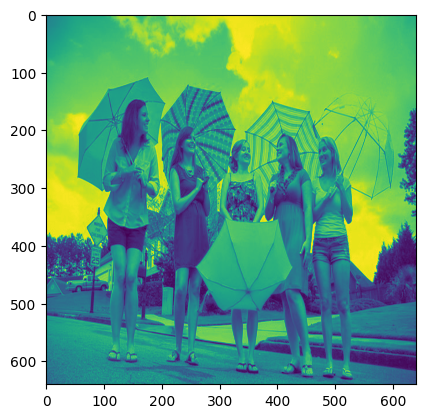

In [344]:
plt.imshow(ort_inputs["images"][0,0,:])

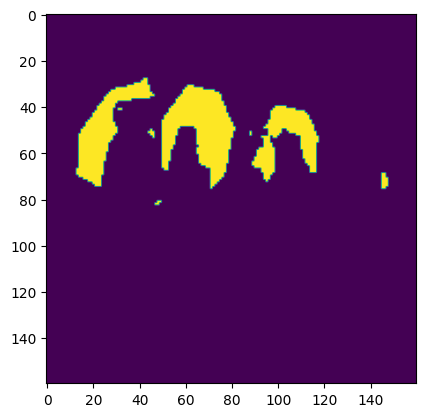

In [349]:
plt.imshow(get_mask(matmuled_masks[6937,:],(0,640,0,640)))

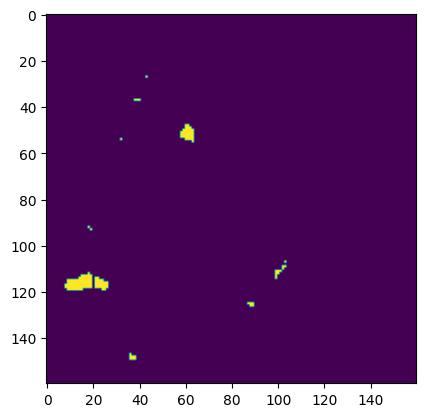

In [351]:
plt.imshow(get_mask(matmuled_masks[4649,:],(0,640,0,640)))

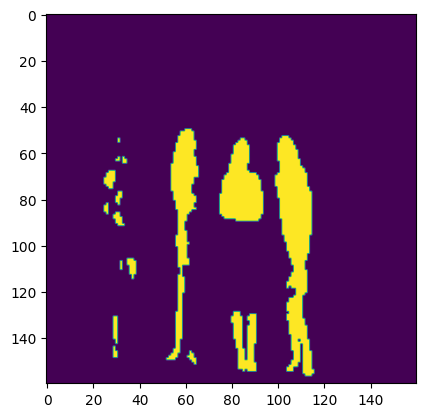

In [353]:
plt.imshow(get_mask(matmuled_masks[7180,:],(0,640,0,640)))

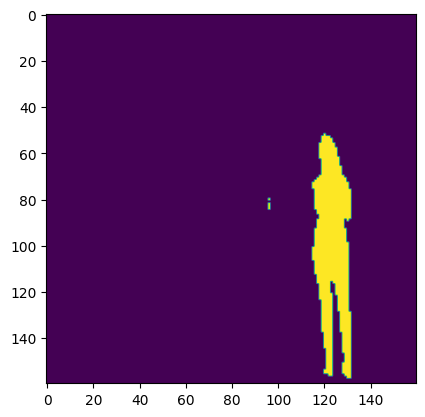

In [346]:
plt.imshow(mask)

In [347]:
def show_mask(boxes, matmuled_masks, index):
    row = boxes.T[index,:]
    prob = row[4:84].max()
    if prob < 0.5: return
    xc,yc,w,h = row[:4]
    class_id = row[4:84].argmax()
    x1 = (xc-w/2)/640*img_width
    y1 = (yc-h/2)/640*img_height
    x2 = (xc+w/2)/640*img_width
    y2 = (yc+h/2)/640*img_height
    # label = yolo_classes[class_id]
    mask = get_mask(matmuled_masks[i,:],(x1,y1,x2,y2))
    # objects.append([x1,y1,x2,y2,label,prob,mask])
    return mask

TypeError: Image data of dtype object cannot be converted to float

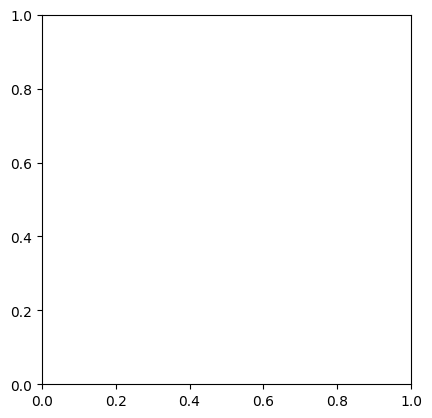

In [348]:
plt.imshow(show_mask(boxes, matmuled_masks, 4))